# Problem Statement:
# **Does paid advertising clicks cause higher/lower conversion than organic visits?**

---


# Simple data cleaning
This section only has data cleaning steps. Its quite boring, so you can just skip if you want.

The analysis is on the next section!

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from io import StringIO
from scipy import stats

%cd C:/Users/neyma/OneDrive/Desktop/work/Project/Google Analytics

C:\Users\neyma\OneDrive\Desktop\work\Project\Google Analytics


C:\Users\neyma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
data = pd.read_csv("GoogleEcommerceData.csv")
data.info()

C:\Users\neyma\AppData\Local\Temp\ipykernel_32040\3705893820.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("GoogleEcommerceData.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fullVisitorId   500000 non-null  object 
 1   visitId         500000 non-null  int64  
 2   medium          500000 non-null  object 
 3   source          500000 non-null  object 
 4   campaign        500000 non-null  object 
 5   deviceCategory  500000 non-null  object 
 6   country         500000 non-null  object 
 7   city            500000 non-null  object 
 8   pageviews       499948 non-null  float64
 9   timeOnSite      251011 non-null  float64
 10  bounces         248352 non-null  float64
 11  revenue         500000 non-null  float64
 12  converted       500000 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 49.6+ MB


In [3]:
data.head(10)
data.nunique()

fullVisitorId     425971
visitId           490541
medium                 7
source               234
campaign               8
deviceCategory         3
country              217
city                 537
pageviews            185
timeOnSite          3725
bounces                1
revenue             3514
converted              2
dtype: int64

This cell is commented out to reduce space taken up in github

In [4]:
# understanding the dataset, what values it gives
# for col in data.columns:
#     print(f"data type is {data[col].dtype} -- AND -- the unique values within {col} are:")
#     if col == 'fullVisitorId' or col == 'visitId' or col == 'timeOnSite':
#         print("too many to give")
#     else:
#         print(data[col].unique())
#     print()

### Weird data values:
From examining the values of each column, we realise that there are some interesting values, namely:
- medium
    - `(none)` = Direct traffic (bookmarks/typed URLs)
    - `(not set)` = Missing tracking data
- source
    - `(direct)` = If medium is `(none)`
    - `(not set)` = Unknown referral source
- campaign
    - `(not set)` = No campaign tags
- Country  & city
    - `(not set)` = Couldn't locate the location

### Most importantly, we see that these data are DIFFERENT FROM NA values, because example: `(none)` or `(not set)` HAVE MEANINGS ENCODED!! SO WE DO NOT "CLEAN" them as they are still useful interpretations from it

In [5]:
types_of_data = {}
# lets see what are the different data types in each columns
for col in data.columns:
    if data[col].dtype in types_of_data:
        types_of_data[data[col].dtype].append(col)
    else:    
        types_of_data[data[col].dtype] = [col]

types_of_data

{dtype('O'): ['fullVisitorId',
  'medium',
  'source',
  'campaign',
  'deviceCategory',
  'country',
  'city'],
 dtype('int64'): ['visitId', 'converted'],
 dtype('float64'): ['pageviews', 'timeOnSite', 'bounces', 'revenue']}

Obj data type O could very possibly mena that there are NULL values within the dataset. I shall nuke the whole dataset

In [6]:
for key, value in types_of_data.items():
    # if key == np.object_:
        for col in value:
            print(f"Column: {col}")
            print("NA SUM:", data[col].isna().sum())
            print('none SUM:', (data[col] ==  "(none)").sum())
            print('not set SUM:', (data[col] ==  "(not set)").sum())
            print()

Column: fullVisitorId
NA SUM: 0
none SUM: 0
not set SUM: 0

Column: medium
NA SUM: 0
none SUM: 204420
not set SUM: 79

Column: source
NA SUM: 0
none SUM: 0
not set SUM: 46

Column: campaign
NA SUM: 0
none SUM: 0
not set SUM: 484155

Column: deviceCategory
NA SUM: 0
none SUM: 0
not set SUM: 0

Column: country
NA SUM: 0
none SUM: 0
not set SUM: 854

Column: city
NA SUM: 0
none SUM: 0
not set SUM: 19247

Column: visitId
NA SUM: 0
none SUM: 0
not set SUM: 0

Column: converted
NA SUM: 0
none SUM: 0
not set SUM: 0

Column: pageviews
NA SUM: 52
none SUM: 0
not set SUM: 0

Column: timeOnSite
NA SUM: 248989
none SUM: 0
not set SUM: 0

Column: bounces
NA SUM: 251648
none SUM: 0
not set SUM: 0

Column: revenue
NA SUM: 0
none SUM: 0
not set SUM: 0



### NA removal?
Seems that the only meaningful NA removalable column is `pageviews`. `timeOnSite` and `bounces` have far too many NAs to nuke, which would literally half the dataset to play with. 
- `bounces` should have NA values replaced with 0, because it implies that the user DID NOT bounce, so we should use `fillna(0)` method to indicate that they did not bounce.

In [7]:
# there are quite a few object types, very vague so we shall take a look deeper, into what combinations there are
for key, value in types_of_data.items():
    if key == np.object_:
        for col in value:
            print(f"Column: {col}")
            print(data[col].apply(type).value_counts())
            print()

Column: fullVisitorId
fullVisitorId
<class 'int'>    393216
<class 'str'>    106784
Name: count, dtype: int64

Column: medium
medium
<class 'str'>    500000
Name: count, dtype: int64

Column: source
source
<class 'str'>    500000
Name: count, dtype: int64

Column: campaign
campaign
<class 'str'>    500000
Name: count, dtype: int64

Column: deviceCategory
deviceCategory
<class 'str'>    500000
Name: count, dtype: int64

Column: country
country
<class 'str'>    500000
Name: count, dtype: int64

Column: city
city
<class 'str'>    500000
Name: count, dtype: int64



So medium, source, campaign, deviceCategory and country are convertable to strings

In [8]:
str_cols = ['medium', 'source', 'campaign', 'deviceCategory', 'country', 'city', 'fullVisitorId']
# convert object columns to string type
for col in str_cols:
    data[col] = data[col].astype(str)

data['medium'] = data['medium'].str.strip().str.lower()
data['bounces'] = data['bounces'].fillna(0).astype(int)

# Check unique values again
print(data['medium'].unique())

['organic' '(none)' 'referral' 'affiliate' 'cpc' 'cpm' '(not set)']


In [9]:
conv = data['converted'] == 1
notconv = data['converted'] == 0
print('converted SUM:', (conv).sum())
print('converted SUM:', (notconv).sum())
print('Conversion ratio:', (conv).sum()*100/((notconv).sum()+(conv).sum()), "%")


converted SUM: 6622
converted SUM: 493378
Conversion ratio: 1.3244 %


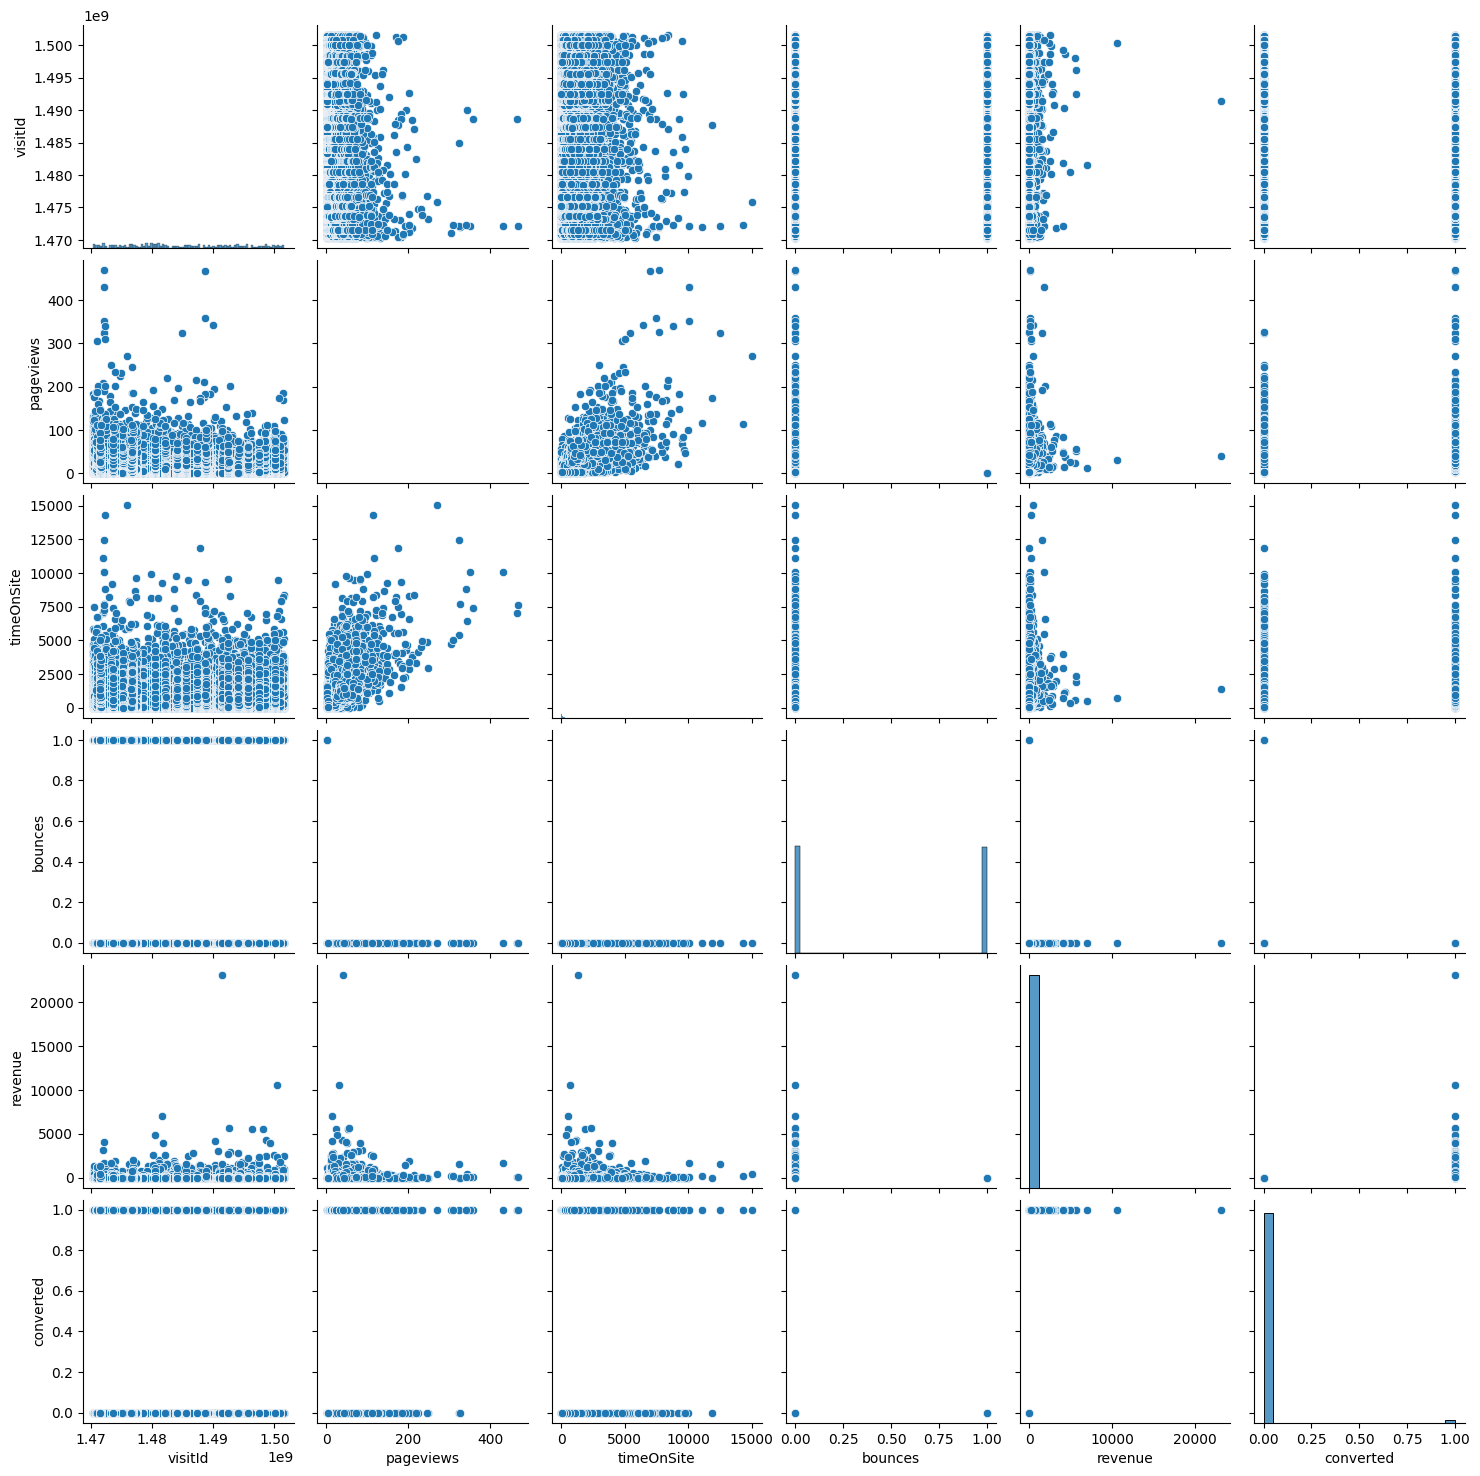

In [10]:
sns.pairplot(data)

# EDA
--- 
## Problem Statement
### **Does paid advertising clicks cause higher/lower conversion than organic visits?**


In this case, 
*Cause of interest* is under `medium` (or Traffic Type)column,
- Treatment: paid traffic (`cpc`+`cpm`)
- Control: `organic` visits through search engines

Thus, we shall focus on these 2 categories (3 values)

> **Note:** The reason why control is ```organic```, instead of ```none```(direct), because we are targeting the *persuadables*, who are people that will convert if targeted by ads, through paid traffic. If it is direct, it means those people are getting into the site through URL typing or bookmarks, which probably means they are **ALREADY PLANNING TO CONVERT**, thus we call them the *sure things*.

*Outcome* is under `converted` column,
- 1 means converted
- 0 means not converted

---

# Therefore, this study shall bear this assumption: **focusing directly on the PERSUADABLES and their conversions.**
in other words, we shall be looking at the effect of `cpm`+`cpc` vs. `organic` on conversion. 

---
> **Note:**  This analysis treats Google Analytics clickstream data as a **general observational study** where *treatment* (paid traffic) occurs naturally via user ad interactions  

----

## **GRAPH 1a**: Conversion Rates by Traffic Medium

Looking at the problem statement, it is natural to visualise the impact of traffic source (`medium`) on converted. But why conversion rate? because we need to normalise against the number of traffic. Essentially, we are just doing this:

$$
\mathbb{E}[\text{converted} \mid \text{medium}]
$$

---

### - Conversion Rate Plot

We use a ***bar plot*** to visualise the **expected conversion rate given traffic medium**:

Since `converted` is a binary variable (0 = no conversion, 1 = conversion), the mean value within each group represents the **proportion of users who converted**.

### - Statistical Significance?

Then, we do a chi-sq test to see if there is truly any statistical significance in difference in conversion rate, for the paid(`cpc`+`cpm`) vs orgainic.


Contingency Table:
[[242, 10775], [1226, 132575]]


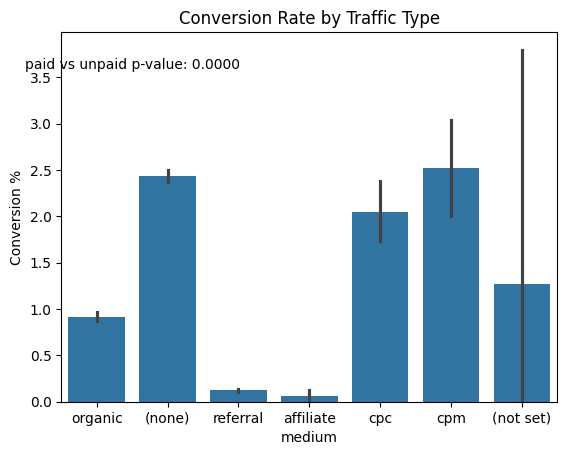

In [11]:
# Conversion rates by medium, eg. out of organic traffic, how many converted.
ax = sns.barplot(data=data, x='medium', y='converted', estimator=lambda x: sum(x)/len(x)*100)
ax.set(title="Conversion Rate by Traffic Type", ylabel="Conversion %")

# run some tests to see if there is a statistically significant difference between paid and organic traffic in terms of conversion
from scipy.stats import chi2_contingency
organic = data[data['medium']=='organic']['converted']
paid = data[(data['medium'] == 'cpc') | (data['medium'] == 'cpm')]['converted']
contingency_table = [
    [sum(paid), len(paid) - sum(paid)],         # paid: converted, not converted
    [sum(organic), len(organic) - sum(organic)]  # organic: converted, not converted
]
print("Contingency Table:")
print(contingency_table)
# Run chi-square test
chi2, pval, dof, expected = chi2_contingency(contingency_table)

# display pvalue on plot
ax.text(0.5, ax.get_ylim()[1] * 0.9, f'paid vs unpaid p-value: {pval:.4f}', ha='center')

plt.show()
# Conclusion: THERE IS A SIGNIFICANT DIFFERENCE BETWEEN PAID AND ORGANIC TRAFFIC IN TERMS OF CONVERSION RATES

## Insights from Graph 1:
- There is statistical significance in the difference btwn paid and organic traffics, as seen from the p-value. 

- As suspected from the previous markdown, `(none)` types have a high conversion rates as they are categorised under *sure things*, and has a lower variance compared to paid (`cpc` + `cpm`). They are steady and probably is going to purchase.

- Nobody likes referral and affiliate links

- Paid have a significantly larger variance than most other traffic types

- `(not set)` has a humongus variance, this value of traffic type may not be useful
---

## **GRAPH 1b**: Converted No. by Traffic Medium

The natural follow up to the above graph is: Even if I know which `medium` is more likely to convert, who are my biggest pile of income? I just want the absolute numbers.

C:\Users\neyma\AppData\Local\Temp\ipykernel_32040\2506356975.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='medium', y='converted', data=data, estimator=np.count_nonzero, ci=None)


<Axes: xlabel='medium', ylabel='converted'>

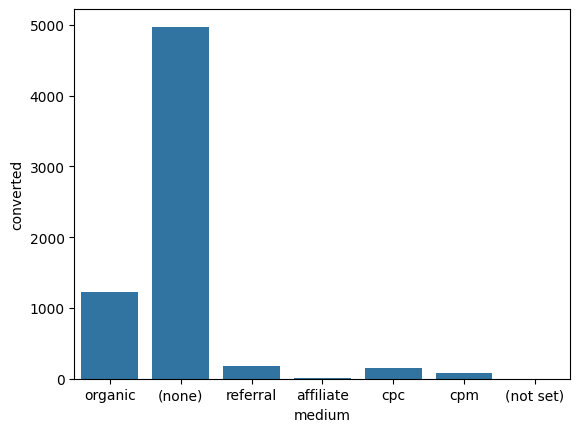

In [12]:
# Just to check who are the ones who converted the most
sns.barplot(x='medium', y='converted', data=data, estimator=np.count_nonzero, ci=None)

## Insights from Graph 1b:

- Again, `(none)` types have a high converted numbers as they are categorised under *sure things*.

- Organic searches have much more converted numbers, but as we know, the proportion in Graph 1a tells a better story. We are simply looking at absolute numbers in 1b
---

## **GRAPH 2a + 2b**: Relationship between Device Type and Traffic Type (`medium`) + Device Type and Conversion 

We want to check if there are any potential biases in the device type and (traffic type or conversion). This could help us in analysing & building the causal graph down the road.

### - 100% Stacked Bar Plot
This normalises each traffic type/ `medium`, allows us to see the proportions of devices rather than the absolute numbers.

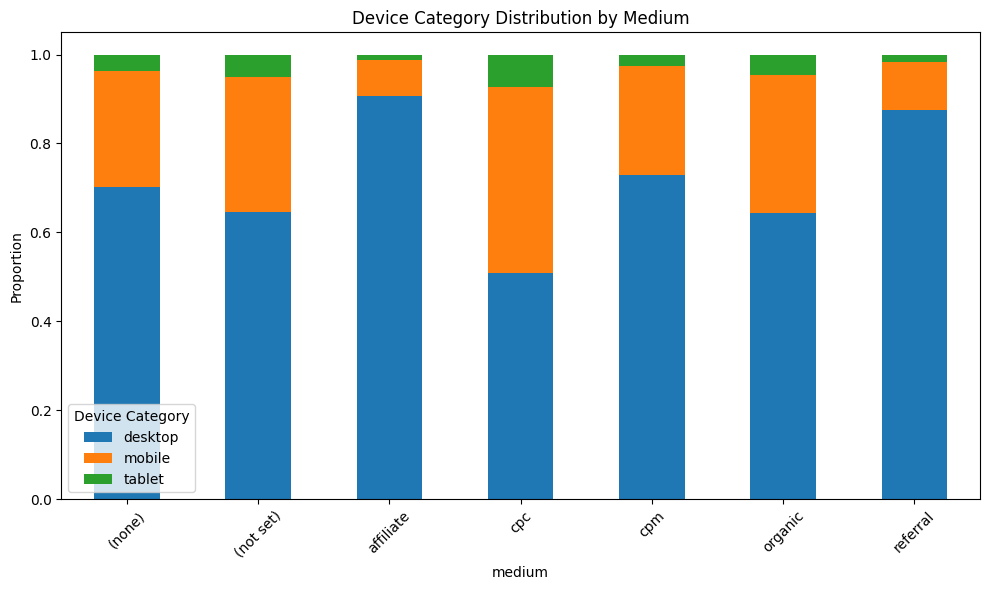

In [13]:
ct = pd.crosstab(data['medium'], data['deviceCategory'])

# normalisation so that we can see proportions rather than absolute numbers
ct_norm = ct.div(ct.sum(axis=1), axis=0)

# Plot the 100% stacked bar chart
ax = ct_norm.plot(kind='bar', stacked=True, figsize=(10,6))

ax.set_ylabel('Proportion')
ax.set_title('Device Category Distribution by Medium')
plt.xticks(rotation=45)
plt.legend(title='Device Category')
plt.tight_layout()
plt.show()

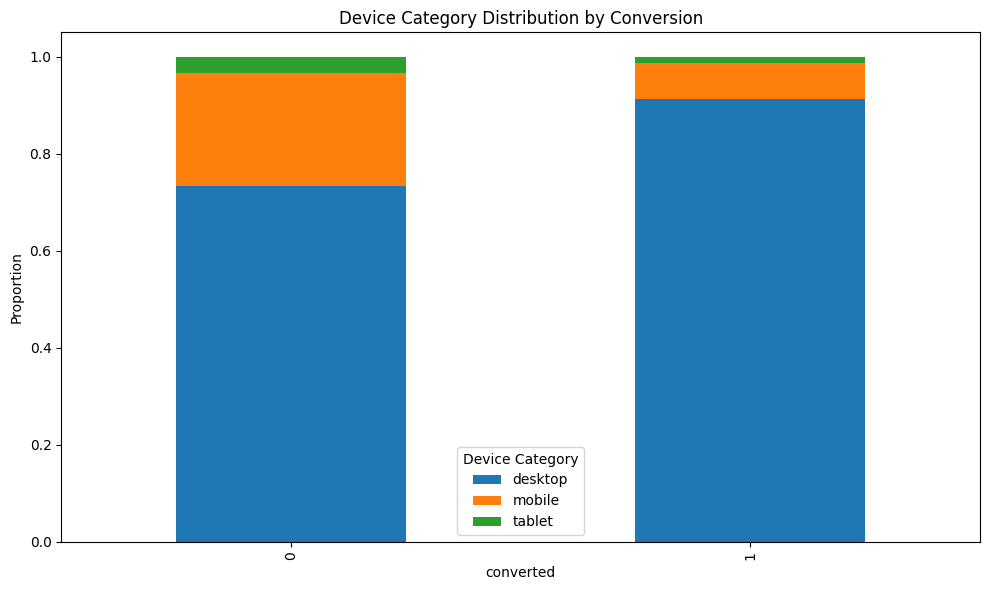

In [14]:
ct1 = pd.crosstab(data['converted'], data['deviceCategory'])
# normalisation so that we can see proportions rather than absolute numbers
ct1_norm = ct1.div(ct1.sum(axis=1), axis=0)

# Plot the 100% stacked bar chart
ax1 = ct1_norm.plot(kind='bar', stacked=True, figsize=(10,6))

ax1.set_ylabel('Proportion')
ax1.set_title('Device Category Distribution by Conversion')
plt.legend(title='Device Category')
plt.tight_layout()
plt.show()

## Insights from Graph 2a + 2b:
- Biggest surprise are affiliate, cpc and referral. `affiliate` & `referral` has much less mobile+tablet device traffic, where `cpc` has SO MUCH MORE mobile+tablet traffic.

- Logically speaking, `cpc` has so much more mobile+tablet traffic is probably due to the nature of device.

<div align="center">
Mobile device usage → Touch-based interaction → More engagement → More ad clicks
</div>

- Thus, `deviceCategory` should be a cause of *treatment* (`medium`), not the other way round. Helps us in our DAG causual diagram later.

- Similarly, people tend to purchase big ticket items on desktops LOL, which is shown in this dataset as well.
---

## **GRAPH 3a + 3b**: Relationship between Countries and Visits + Countries and Conversion

- 3a shows us countries with the biggest potential, as they are the ones visiting our website the most.

On the other hand,
- 3b shows us who are our biggest customers, purchasing most of our products.


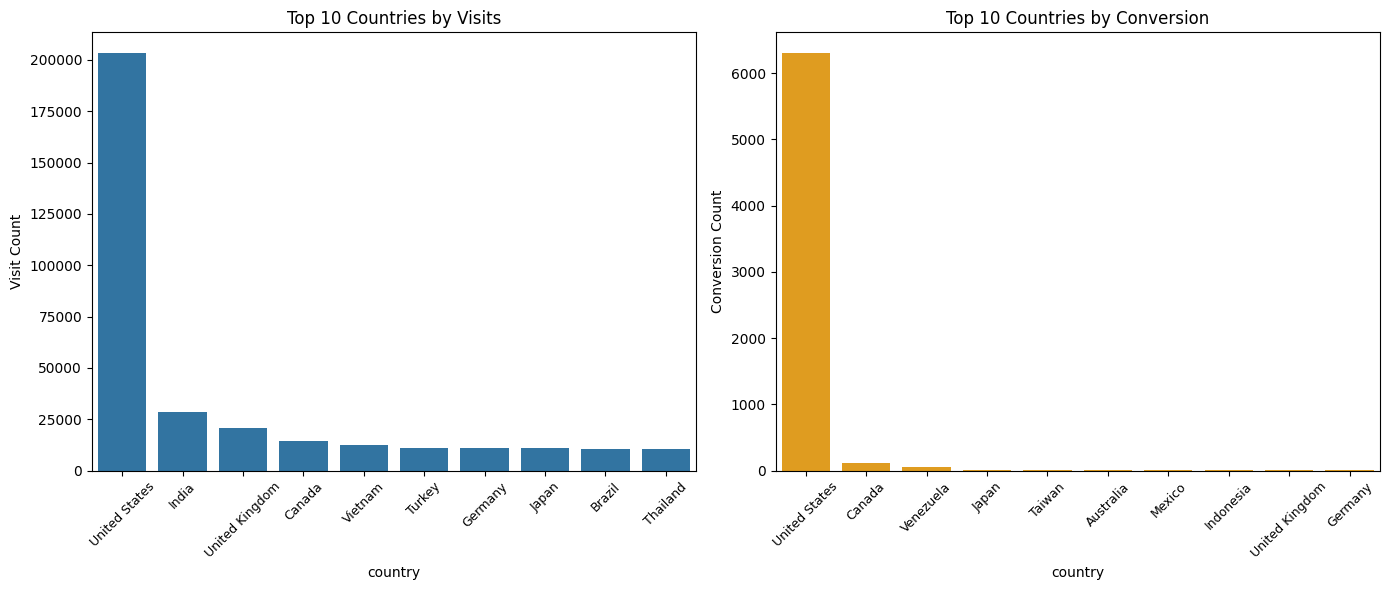

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 3a: Top 10 countries by visits
top_countries = data['country'].value_counts().head(10).index
sns.countplot(data=data[data['country'].isin(top_countries)],
              x='country',
              order=top_countries,
              ax=axes[0])
axes[0].set_title("Top 10 Countries by Visits")
axes[0].set_ylabel("Visit Count")
axes[0].tick_params(axis='x', labelrotation=45, labelsize=9)

# Plot 3b: Top 10 countries by conversions
top_countries_conversion = data[data['converted'] == 1]['country'].value_counts().head(10).index
sns.countplot(data=data[(data['converted'] == 1) & (data['country'].isin(top_countries_conversion))],
              x='country',
              order=top_countries_conversion,
              ax=axes[1],
              color='orange')
axes[1].set_title("Top 10 Countries by Conversion")
axes[1].set_ylabel("Conversion Count")
axes[1].tick_params(axis='x', labelrotation=45, labelsize=9)

plt.tight_layout()
plt.show()

## Insights from Graph 3a + 3b:

- By far, US has the most visits AND conversion count. This could possibly mean that this dataset is ***extremely skewed towards the US audience***, and we definitely need to ***find a way to eliminate this bias further down the causal inference analysis***.

- India, Vietnam, Turkey, Brazil and Thailand are in the top 10 most visited, but not in the most conversion counts, potentially missing out.
---

## **GRAPH 4**: Pageviews on medium and conversion

Chi2: 102530.34334867938, p-value: 0.0000, dof: 184


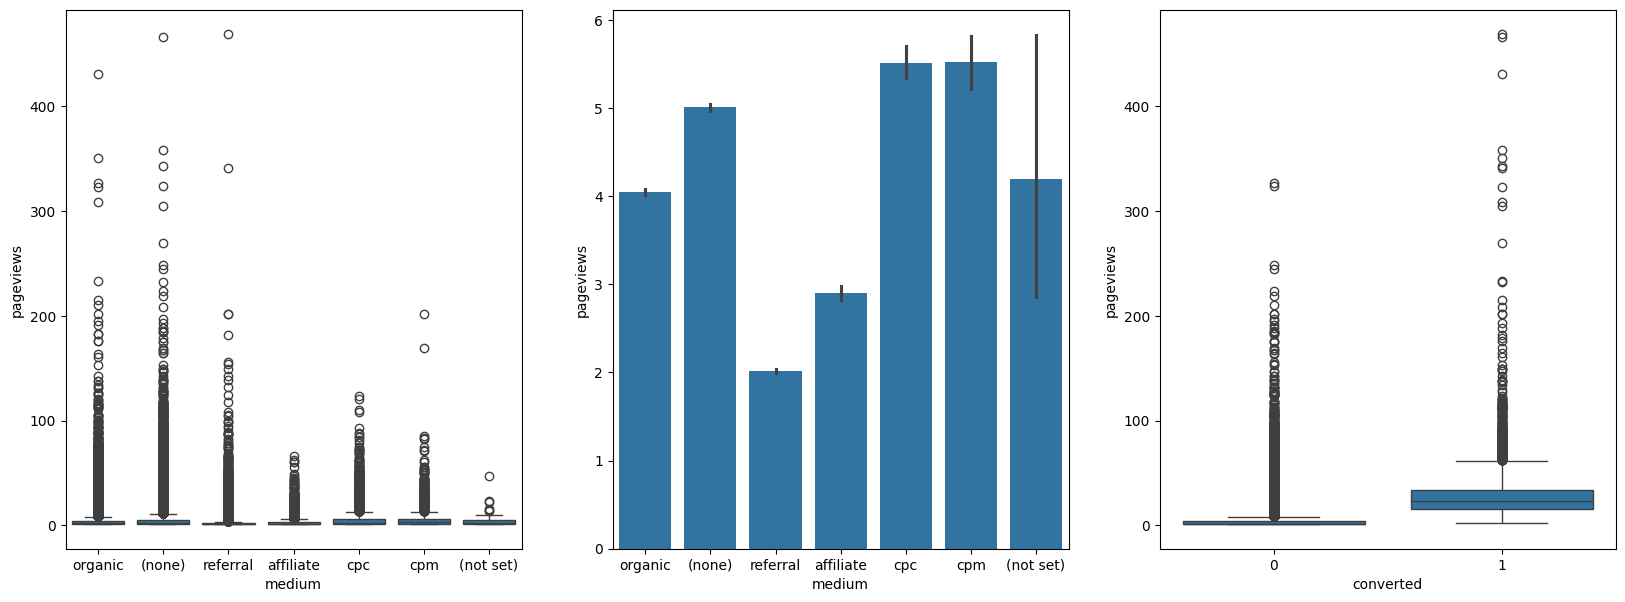

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
sns.boxplot(data=data, x='medium', y='pageviews',ax=axes[0])
data.groupby('medium')['pageviews'].mean()
sns.barplot(data=data, x='medium', y = 'pageviews' , estimator='mean', ax=axes[1])
sns.boxplot(data=data, x='converted', y='pageviews',ax=axes[2])


chi2, pval, dof, expected = chi2_contingency(pd.crosstab(data['converted'], data['pageviews']))

print(f"Chi2: {chi2}, p-value: {pval:.4f}, dof: {dof}")

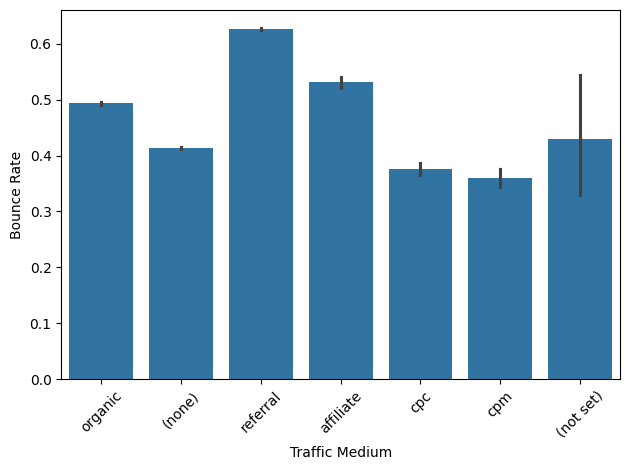

In [17]:
# (data.groupby('medium')['bounces']
#      .mean()
#      .plot(kind='bar', title='Bounce Rate by Medium'))

sns.barplot(data=data, x='medium', y='bounces', estimator=np.mean)

plt.ylabel('Bounce Rate')
plt.xlabel('Traffic Medium')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# higher is worse

In [18]:
# Just a quick correlation analysis to see if i can infer anything for causal relationships
# THIS DOES NOT MEAN CAUSATION = CORRELATION: I AM SIMPLY LOOKING FOR POTENTIAL CAUSAL RELATIONSHIPS, BY INFERING FROM CORRELATION
numeric_data = data.select_dtypes(include=['number'])
corr = numeric_data.corr()
corr.iloc[1:, 1:] # cuz the first data column is 'visitId' which is not relevant for correlation analysis

,pageviews,timeOnSite,bounces,revenue,converted
pageviews,1.000000,0.642901,-0.401598,0.162945,0.403406
timeOnSite,0.642901,1.000000,NaN,0.110638,0.273990
bounces,-0.401598,NaN,1.000000,-0.033716,-0.115091
revenue,0.162945,0.110638,-0.033716,1.000000,0.292951
converted,0.403406,0.273990,-0.115091,0.292951,1.000000


<Axes: >

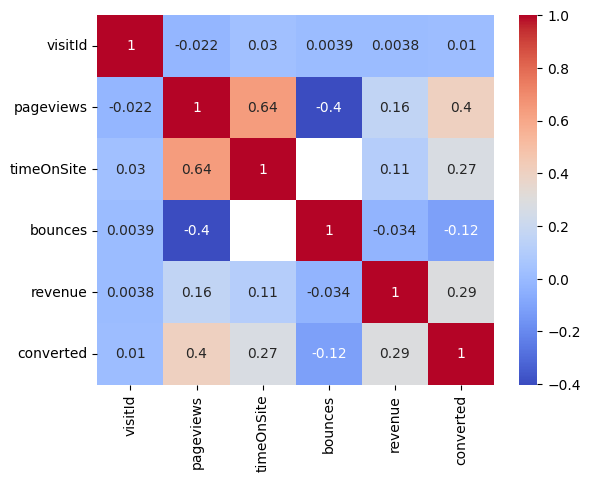

In [19]:
sns.heatmap(data.corr(numeric_only=True), cmap='coolwarm',annot=True)

## Casual DAG

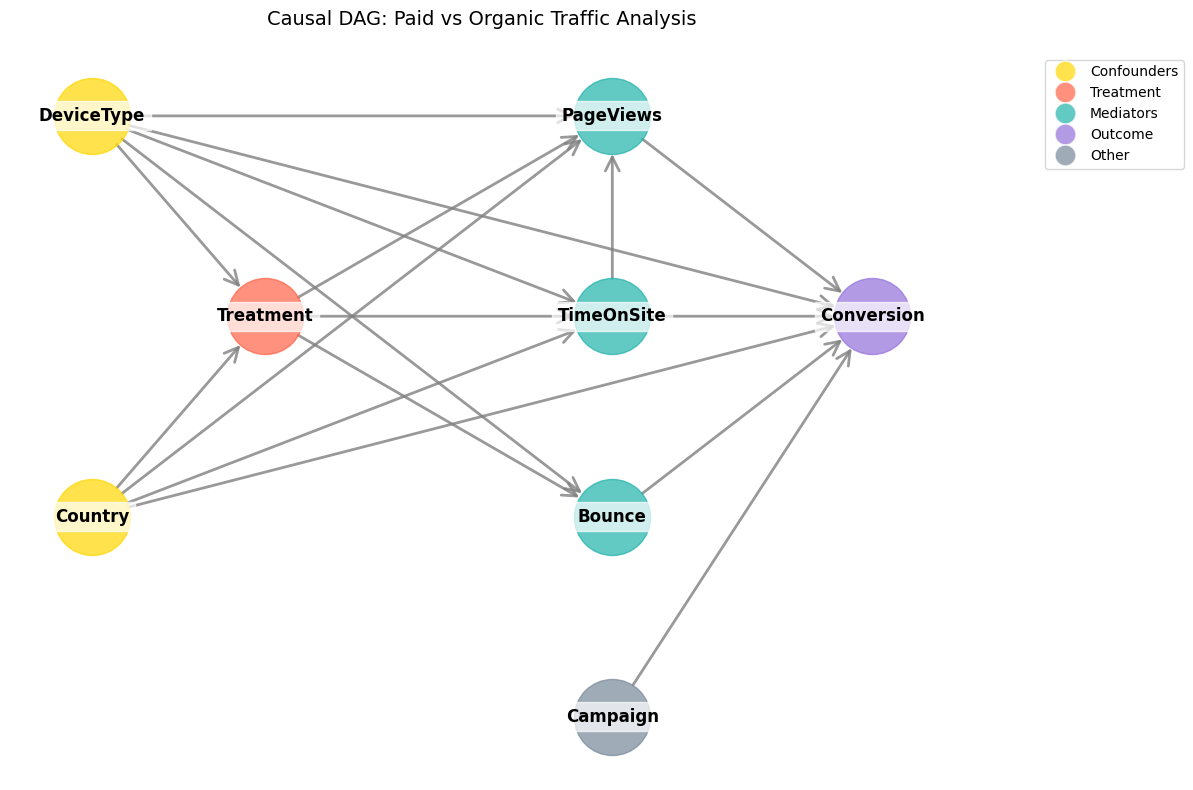

In [20]:

plt.figure(figsize=(12, 8))

# Initialize graph
G = nx.DiGraph()

# Add nodes with type classification
confounders = ['DeviceType', 'Country']
treatment = ['Treatment']
mediators = ['PageViews', 'TimeOnSite', 'Bounce']
outcome = ['Conversion']
other = ['Campaign']

# Add edges
edges = [
    ('DeviceType', 'Treatment'),
    ('DeviceType', 'Conversion'),
    ('Country', 'Treatment'),
    ('Treatment', 'PageViews'),
    ('Treatment', 'TimeOnSite'), 
    ('Treatment', 'Bounce'),
    ('DeviceType', 'PageViews'),
    ('DeviceType', 'TimeOnSite'),
    ('DeviceType', 'Bounce'),
    ('Country', 'PageViews'),
    ('Country', 'TimeOnSite'),
    ('PageViews', 'Conversion'),
    ('TimeOnSite', 'Conversion'),
    ('TimeOnSite', 'PageViews'),
    ('Bounce', 'Conversion'),
    ('Country', 'Conversion'),
    ('Campaign', 'Conversion')
]

G.add_edges_from(edges)

# Improved layout with more spacing
pos = {
    'DeviceType': (0, 1.5),
    'Country': (0, -1.5),
    'Treatment': (2, 0),
    'PageViews': (6, 1.5),
    'TimeOnSite': (6, 0),
    'Bounce': (6, -1.5),
    'Conversion': (9, 0),
    'Campaign': (6, -3)
}

# Draw nodes with transparency
nx.draw_networkx_nodes(G, pos, node_size=3000,
                      nodelist=confounders, node_color='#FFD700', alpha=0.7)  # Semi-transparent
nx.draw_networkx_nodes(G, pos, node_size=3000,
                      nodelist=treatment, node_color='#FF6347', alpha=0.7)
nx.draw_networkx_nodes(G, pos, node_size=3000,
                      nodelist=mediators, node_color='#20B2AA', alpha=0.7)
nx.draw_networkx_nodes(G, pos, node_size=3000,
                      nodelist=outcome, node_color='#9370DB', alpha=0.7)
nx.draw_networkx_nodes(G, pos, node_size=3000,
                      nodelist=other, node_color='#778899', alpha=0.7)

# Draw edges with visible arrowheads
nx.draw_networkx_edges(
    G, pos, 
    edge_color='gray',
    arrows=True,
    arrowsize=25,  # Larger arrowheads
    arrowstyle='->',  # Solid arrow style
    width=2,
    node_size=3000,  # Match node size
    alpha=0.8,
    min_source_margin=20,  # Add space before arrows
    min_target_margin=20   # Add space after arrows
)

# Labels with white background for readability
label_options = {"ec": "white", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', bbox=label_options)

# Legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Confounders',
              markerfacecolor='#FFD700', markersize=15, alpha=0.7),
    plt.Line2D([0], [0], marker='o', color='w', label='Treatment',
              markerfacecolor='#FF6347', markersize=15, alpha=0.7),
    plt.Line2D([0], [0], marker='o', color='w', label='Mediators',
              markerfacecolor='#20B2AA', markersize=15, alpha=0.7),
    plt.Line2D([0], [0], marker='o', color='w', label='Outcome',
              markerfacecolor='#9370DB', markersize=15, alpha=0.7),
    plt.Line2D([0], [0], marker='o', color='w', label='Other',
              markerfacecolor='#778899', markersize=15, alpha=0.7)
]

plt.legend(handles=legend_elements, loc='upper right', 
          bbox_to_anchor=(1.25, 1), fontsize=10)

plt.title("Causal DAG: Paid vs Organic Traffic Analysis", 
         fontsize=14, pad=20)
plt.axis('off')
plt.tight_layout()

# # Save with high DPI
# plt.savefig('causal_dag.png', dpi=300, bbox_inches='tight')
# plt.show()

We now want to block the backdoor paths, ie. condition on certain variables so that we can prevent confounding bias, isolating the TRUE effect of the treatment.

However, do note that we should not just block every variable that is not directly casual, because this can lead to Berkson's paradox. Just block the right number of variables.

---

### Variables to Condition On (Block)

- **DeviceType**  
- **Country**  

These variables are **common causes (forks)** of both the treatment and the outcome. Conditioning on them blocks backdoor paths that could confound the treatment effect.

---

### Variables Not to Condition On

- **Campaign**  

This variable does **not affect the causal relationship** between treatment and outcome in our graph and can be safely left out.

- **The 3 Mediators** (variables on the causal path from treatment to outcome)  
    - PageViews
    - TimeOnSite
    - Bounce

**Do not condition on mediators**, as blocking them would block part of the causal effect we want to measure.

---

### Summary

| Variable Type | Examples       | Should Condition On? | Reason                                    |
|---------------|----------------|---------------------|-------------------------------------------|
| Confounders   | DeviceType, Country | ✅ Yes              | Block backdoor paths (common causes)      |
| Treatment-irrelevant | Campaign       | ❌ No               | No impact on causal path                   |
| Mediators     | PageViews, TimeOnSite (example) | ❌ No               | Blocking would block causal effect itself |

---


After conditioning on the confounders, we can now estimate the **causal effect of paid traffic on conversion** using statistical methods like regression analysis or propensity score matching.
Average treatment effect (ATE) can be estimated by comparing the average conversion rates between the treatment and control groups after conditioning on the confounders.

---
The code below is simply narrowing down the dataset:
1. filtering the dataset to only include `cpc`, `cpm`, and `organic` traffic types
2. binary treatment of paid traffic or not 
2. creating indicator columns for `deviceCategory` and `country`

In [21]:
# Narrow down the rows to look at now.
values_to_concentrate = ['organic', 'cpc', 'cpm']
dfnew = data[data['medium'].isin(values_to_concentrate)].copy() # so that i dont edit the data dataframe

# Make the treatment 'is paid' a binary
dfnew['is paid'] = (dfnew['medium'].isin(['cpc','cpm'])).astype(int)

# Now make the categorial data into indicator variables, so that we can parse through ML models
dfnew = pd.get_dummies(dfnew, columns=['deviceCategory', 'country'], drop_first=True,dtype=int) # drop the first to reduc no of variables
pd.crosstab(dfnew['is paid'],dfnew['converted']) # quick confusion matrix


converted,0,1
is paid,,
0,132575,1226
1,10775,242


In [22]:
dfnew.shape
# took out about 350,000 rows

(144818, 208)

# Model 1: Logistic Regression
We first estimate the treatment effect using a logistic regression model that predicts conversion probability based on treatment status and covariates:
$$\mathbb{P}(\text{converted}=1)=logit^{−1}(β_0 + β_1⋅is paid+β_2⋅country+β_3⋅device)$$

This approach estimates the **average marginal effect** (AME) by comparing conversion between paid and organic traffic users who have the same device category and country. The marginal effect of the treatment variable (`is paid`) gives us the average change in conversion probability when users switch from organic to paid traffic, holding all other covariates constant.
The key assumption is that conditional on device and country, treatment assignment is independent of potential outcomes - meaning there are no unmeasured confounders that simultaneously affect both traffic source and conversion rates.

In [23]:
import statsmodels.api as sm
X = dfnew[['is paid'] +[col for col in dfnew.columns if 'deviceCategory_' in col or 'country_' in col]]
Y = dfnew['converted']
X = sm.add_constant(X)

logmodel = sm.Logit(Y,X)
result = logmodel.fit()
print(result.summary())
# something is wrong, and we debugged it below

C:\Users\neyma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\neyma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

## Problem with Data
Singular matrix error suggests that the data is not suitable for certain statistical methods, likely due to multicollinearity or insufficient variation in the data. We can see why the data is not suitable in the cell below.

In [24]:
# singular matrix, meaning that there is a near perfect linear relationship with one or more of the variables
for col in X.columns[4:9]: #take the first 5 countries as an example
    print(f"\n--- {col} ---")
    print(pd.crosstab(X[col], Y))


--- country_Afghanistan ---
converted                 0     1
country_Afghanistan              
0                    143338  1468
1                        12     0

--- country_Albania ---
converted             0     1
country_Albania              
0                143316  1468
1                    34     0

--- country_Algeria ---
converted             0     1
country_Algeria              
0                143319  1468
1                    31     0

--- country_Andorra ---
converted             0     1
country_Andorra              
0                143349  1468
1                     1     0

--- country_Angola ---
converted            0     1
country_Angola              
0               143347  1468
1                    3     0


## Fixing the data
As we can see, there are **many countries with very few visits, and also very few conversions**. This can cause the logistic regression to fail, because the model is has unpredictable coefficients, most likely having singular predictions, thus the singular matrix error. (quasi-perfect separation)

    Example:

    Country X: 3 visits, 0 conversions → conversion rate = 0%
    Country Y: 2 visits, 2 conversions → conversion rate = 100%

    The model tries to fit coefficients for these extreme cases, leading to:

    - Huge coefficient values (trying to predict 0% vs 100%)
    - Unstable estimates (small changes in data drastically change results)
    - Perfect multicollinearity — one column is a perfect linear combo of others, causing singular matrix errors 

---

To fix this, we only included countries with more than 10 conversions to discard small data.

In [25]:
# Narrow down the rows to look at now.
values_to_concentrate = ['organic', 'cpc', 'cpm']
dfnew = data[data['medium'].isin(values_to_concentrate)].copy() # so that i dont edit the data dataframe

# Make the treatment 'is paid' a binary
dfnew['is paid'] = (dfnew['medium'].isin(['cpc','cpm'])).astype(int)

# New step: only take the countries with more converted values
country_conversions = data.groupby('country')['converted'].sum()
contries_to_consider = country_conversions[country_conversions>=10].index
print(contries_to_consider)
df_filtered1 = dfnew[dfnew['country'].isin(contries_to_consider)].copy()


df_filtered = pd.get_dummies(df_filtered1, columns=['deviceCategory', 'country'], drop_first=True)
print(df_filtered.columns)


Index(['Australia', 'Canada', 'Japan', 'Mexico', 'Taiwan', 'United States',
       'Venezuela'],
      dtype='object', name='country')
Index(['fullVisitorId', 'visitId', 'medium', 'source', 'campaign', 'city',
       'pageviews', 'timeOnSite', 'bounces', 'revenue', 'converted', 'is paid',
       'deviceCategory_mobile', 'deviceCategory_tablet', 'country_Canada',
       'country_Japan', 'country_Mexico', 'country_Taiwan',
       'country_United States', 'country_Venezuela'],
      dtype='object')


### Logistic Regression: *Confounder variables + `is paid` against Outcome*
$$\mathbb{P}(\text{converted} = 1 \mid \text{is paid, deviceCategory, country})$$

In [26]:
X = df_filtered[['is paid'] +[col for col in df_filtered.columns if 'deviceCategory_' in col or 'country_' in col]]
Y = df_filtered['converted']
X = sm.add_constant(X)

bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)

logmodel = sm.Logit(Y,X)
result = logmodel.fit(maxiter=100)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.085816
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                78605
Model:                          Logit   Df Residuals:                    78595
Method:                           MLE   Df Model:                            9
Date:                Thu, 24 Jul 2025   Pseudo R-squ.:                 0.05347
Time:                        14:13:09   Log-Likelihood:                -6745.6
converged:                       True   LL-Null:                       -7126.6
Covariance Type:            nonrobust   LLR p-value:                2.960e-158
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -7.7418      1.000     -7.740      0.000      -9.702      -5

# Interpreting the Model 1

## Model Analysis
> Note: Since we are simply trying to explain the causal effect, prediction (AUC) and model selection metrics (AIC) or Log-Likelihood is not very useful to for our causal inference model.

| Statistic           | Value         |
|---------------------|---------------|
| **Log-Likelihood**  | -6745.6       |
| **LL-Null**         | -7126.6       |
| **Likelihood Ratio Test (LLR) p-value** | 2.960 × 10⁻¹⁵⁸ |

This means that this Logistic Regression is *better* than null model, and is *significant*.



---

## Variable analysis

The intercept (`const`) is **−7.7418**, which implies that the **baseline log-odds** of conversion — for a user who is:
- On **organic traffic**
- Using a **desktop**
- From **Australia** (assuming Australia was the dropped category)
  
is:

$$
\text{Odds} = e^{-7.7418} \approx 0.00043
$$

This reflects a **very low baseline probability** of conversion.

---

### Interpreting Other Coefficients

Each coefficient represents the **change in log-odds of conversion**, relative to the baseline. (CONSIDER THE PVALUES TOO)

 `is paid` = **0.1940**
- Being in a **paid medium** (cpc or cpm) increases the log-odds by 0.1940.
- The odds ratio is:

$$
e^{0.1940} \approx 1.2139
$$

→ This means paid traffic has **21.4% higher odds** of conversion, *all else being equal*, at a **0.007 p-value**. (ie. could only observe this or more extreme with 0.7% of the time by chance, statistically significant)

---

 `deviceCategory_mobile` = **−1.2429**
- Using a **mobile device** decreases log-odds by −1.2429.
- The odds ratio is:


$$e^{-1.2429} \approx 0.2885
$$

→ Mobile users have **about 71% lower odds** of conversion than desktop users, *all else being equal*.

---

> To interpret any other variable, just apply:
> $$
> \text{Odds Ratio} = e^{\text{coefficient}}
> $$
> and compare against the baseline category.
> remember to check the p-values too, as they indicate statistical significance.

---

However, we are not done yet! We simply checked whether there might be a relationship betweeen `country` + `deviceCategory` against `conversion`. 

> ***We have not checked for if it has a relationship with the treatment (`is paid`) as the y, which is the next step.***

### Logistic Regression: *Potential Confounder variables against Treatment*

Essentially,
$$\mathbb{P}(\text{is paid} = 1 \mid \text{deviceCategory, country}) = \frac{1}{1 + e^{-(\beta|_0 + \beta_1 X_1 + \dots + \beta_k X_k)}}$$

This step is to:
1. Support our DAG if `deviceCategory` and `country` does associate with treatment (Note that is support and associate, doesn't confirm causal)
2. Builds up the foundation for Model 2: PSM

In [27]:
# this time, y shall be treatment/is paid. We are seeing if devicecat and country affects treatment
X1 = df_filtered[[col for col in df_filtered.columns if 'deviceCategory_' in col or 'country_' in col]]
Y1 = df_filtered['is paid']
X1 = sm.add_constant(X1)

bool_cols = X1.select_dtypes(include='bool').columns
X1[bool_cols] = X1[bool_cols].astype(int)

logmodel1 = sm.Logit(Y1,X1)
result1 = logmodel1.fit(maxiter=100)
print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.370375
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                is paid   No. Observations:                78605
Model:                          Logit   Df Residuals:                    78596
Method:                           MLE   Df Model:                            8
Date:                Thu, 24 Jul 2025   Pseudo R-squ.:                 0.04723
Time:                        14:13:09   Log-Likelihood:                -29113.
converged:                       True   LL-Null:                       -30556.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -5.3435      0.251    -21.303      0.000      -5.835      -4.

## Interpreting the results
Again, very similar to the previous logistic regression, we can interpret the coefficients in a similar way, which I will not repeat the same steps as it is unnecessary. I will only point out the key insights.

### Insights from the next logistic regression
United States, Canada and Mexico seems to have the most paid traffic. This could potentially mean that this dataset/ marketing advertisement is mainly done in America!

The difference in magnitudes of coefficients and low p-values shows that `deviceCategory` and several `country` significantly predict the likelihood of receiving paid traffic (`is paid`). This supports our causal graph assumptions.

---

Thus, we can conclude that the `deviceCategory` and `country` variables are **highly likely confounders**, due to their high association with both treatment and control, but this is if my casual graph/ assumptions holds true.

## Getting the Average Marginal Effect (AME)
Now that we got the models, we should take a look at the average treatment effect. Essentially:
$$
\text{AME} = \frac{1}{n}\sum_{i=1}^n \left[ \underbrace{P(Y_i=1|T_i=1,X_i)}_{\text{Probability if treated}} - \underbrace{P(Y_i=1|T_i=0,X_i)}_{\text{Probability if control}} \right]
$$
Where:
- $X_i$ are confounder variables (`deviceCategory`, `country`)
- $Y_i$ is the outcome (`converted`)
- $T_i$ is the treatment (`is paid`)

We are trying to see what is the average change in conversion probability if EVERYONE *in our data* switched from organic to paid traffic, after conditioning on the confounders. 

---

> ***AME != ATE***, its iff:
> 1. When this sample is representative of the population
> 2. When this regression model is correctly specified
> 3. When there is no unmeasured confounders

> ### **WE SHALL ASSUME THAT THE ABOVE IS TRUE, THUS AME = ATE in this case**

> TLDR, AME is only an estimate for ATE. There are conditions that need to be met for AME = ATE, but many observational studies simply says ATE because they assume those conditions hold

In [28]:
marginaleff = result.get_margeff()
print(marginaleff.summary())
print('Log Reg ATE:',marginaleff.summary_frame().loc['is paid']['dy/dx'])

        Logit Marginal Effects       
Dep. Variable:              converted
Method:                          dydx
At:                           overall
                           dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
is paid                   0.0034      0.001      2.685      0.007       0.001       0.006
deviceCategory_mobile    -0.0219      0.001    -14.818      0.000      -0.025      -0.019
deviceCategory_tablet    -0.0177      0.003     -5.899      0.000      -0.024      -0.012
country_Canada            0.0503      0.018      2.803      0.005       0.015       0.086
country_Japan             0.0323      0.019      1.668      0.095      -0.006       0.070
country_Mexico            0.0267      0.022      1.236      0.217      -0.016       0.069
country_Taiwan            0.0336      0.020      1.702      0.089      -0.005       0.072
country_United States     0.0738      

## Insights from AME

The dy/dx of `is paid` is 0.0034. 

---

> ## Controlling for *device* and *country*, paid traffic *increases conversion probability by 0.34%* points on average

## Model 2: Propensity Score Matching using NN algorithm
a quasi-experimental ***matching*** design to get **Average Treatment Effect** (ATE)

---

Step 1: Calculate propensity score for each row, that would receive this treatment, conditioned on the confounders. (ie. using the previous model to do prediction on every row)
$$\mathbb{P}(\text{is paid} = 1 \mid \text{deviceCategory, country}) $$

Step 2: Match treated and control units with similar propensity scores using nearest neighbor algorithm
- For each treated unit (is paid = 1), find the control unit (is paid = 0) with the closest propensity score
- Use 1:1 matching without replacement to create balanced pairs
- This creates a "quasi-experimental" design where treatment assignment is approximately random within matched pairs

Step 3: Calculate ATE by comparing outcomes between matched groups
$$\text{ATE} = \frac{1}{N_{\text{matches}}} \sum_{i=1}^{N_{\text{matches}}} \left[ Y_i^{\text{is paid}} - Y_i^{\text{organic}} \right]$$


---

### Key Assumption: **Unconfoundedness**
After conditioning on propensity scores, treatment assignment is independent of potential outcomes:
$$Y^0, Y^1 \perp T \mid e(X)$$

Where $e(X)$ is the propensity score and $Y^0, Y^1$ are potential outcomes under control and treatment.

In other words, the potential outcomes are independent of your treatment, given your propensity score (how likely you are to recieve treatment/ condition on confounders). 

---

### Theoretical Understanding

Among users with the same propensity score (same chance to recieve treatment), the chance of treatment will now be theoretically random! VERY IMPORTANT!!

This leads to a quasi-parallel world/ experimental comparison, the difference in whether you convert or not could only be from the treatment! In python:

```python
ate = treated_outcomes.mean() - control_outcomes.mean()
```
> This gives us the average difference in conversion probability treated vs. untreated

In [29]:
from causalml.match import NearestNeighborMatch

# Step 1
# add a column propensity score for the prediciton based on logmodel1
df_filtered['propensity_score'] = result1.predict(X1)


# Step 2
# we match treated + control units with simalr propensity scores
matcher = NearestNeighborMatch(replace=False, ratio=1, random_state=69)
matched_indices = matcher.match(
    data=df_filtered,
    treatment_col='is paid',
    score_cols=['propensity_score']
)

# True or False values per row of matched_indices
treated_mask = matched_indices['is paid'] == 1
control_mask = matched_indices['is paid'] == 0

# each outcome is a column of converted or not, a 0 or 1!!
treated_outcomes = matched_indices.loc[treated_mask, 'converted']
control_outcomes = matched_indices.loc[control_mask, 'converted']

# Step 3 
# calculate ATE
ate = treated_outcomes.mean() - control_outcomes.mean()
print(f"PSM ATE: {ate:.4f}")
print(f"Number of matches: {len(treated_outcomes)}")

PSM ATE: 0.0038
Number of matches: 10316


Bootstrap to get CI

In [30]:
def bootstrap_ate():
    idx = np.random.choice(len(treated_outcomes), size=len(treated_outcomes), replace=True)
    return treated_outcomes.iloc[idx].mean() - control_outcomes.iloc[idx].mean()

bootstrap_ates = [bootstrap_ate() for _ in range(1000)]
psm_ci_lower, psm_ci_upper = np.percentile(bootstrap_ates, [2.5, 97.5])
print(f"IPW 95% CI: [{psm_ci_lower:.4f}, {psm_ci_upper:.4f}]")

IPW 95% CI: [-0.0002, 0.0078]


## Interpreting Model 2:

> ## Using Propensity Score Matching, paid traffic **increases conversion probability of 0.38%** than similar organic visits.

## Model 3: Inverse Probability Weighting (IPW)
***reweights*** your data to make the treated and control groups more comparable, as if they came from a randomised experiment.

---

Weights:
- Treated: $w_i = \frac{1}{e(X_i)}$ where $e(X_i) = P(\text{is paid}|X_i)$
- Control: $w_i = \frac{1}{1-e(X_i)}$

> Reminder: $X_i$ is the confounders for row $i$, $e(X_i)$ is the propensity score (probability of treatment given those confounders)

The idea here is so that the people with *"rarer" treatment* have higher weightage and vice versa. This would theoretically even out the treatment biasness within the dataset, and simulate a randomised experiment

---

$$
ATE = \frac{\sum w_i Y_i T_i}{\sum w_i T_i} - \frac{\sum w_i Y_i (1-T_i)}{\sum w_i (1-T_i)}
$$


In [31]:
# Step 1: 
# from previos data
propensity_scores = df_filtered['propensity_score']
treatment = df_filtered['is paid']
outcome = df_filtered['converted']

# Step 2: 
# Calculate weights
weights = np.where(treatment == 1, 
                   1 / propensity_scores,           # Treated: 1/P(T=1|X)
                   1 / (1 - propensity_scores))     # Control: 1/P(T=0|X)

# Step 3: 
# Separate masks for treated and control
treated_mask = treatment == 1
control_mask = treatment == 0

# Step 4: 
# Calculate weighted mean outcomes
treated_weighted_outcome = np.average(outcome[treated_mask], 
                                      weights=weights[treated_mask])

control_weighted_outcome = np.average(outcome[control_mask], 
                                      weights=weights[control_mask])

# Step 5: 
# Compute ATE
ate_ipw = treated_weighted_outcome - control_weighted_outcome

print(f"IPW ATE: {ate_ipw:.4f}")
print(f"Treated weighted outcome: {treated_weighted_outcome:.4f}")
print(f"Control weighted outcome: {control_weighted_outcome:.4f}")
print(f"Sample size: {len(df_filtered)}")

ipw_results = {
    'ate_ipw': ate_ipw,
    'treated_outcome': treated_weighted_outcome,
    'control_outcome': control_weighted_outcome,
    'weights': weights
}


IPW ATE: 0.0029
Treated weighted outcome: 0.0205
Control weighted outcome: 0.0176
Sample size: 78605


Bootstrap as well

In [32]:
def bootstrap_ipw():
    # RESET INDEX AT BOOTSTRAP LEVEL
    idx = np.random.choice(len(outcome), size=len(outcome), replace=True)
    idx = pd.Series(idx).reset_index(drop=True)  # Force sequential indices
    
    # Convert ALL to numpy to avoid Pandas indexing
    w_treated = weights[idx][treated_mask.to_numpy()[idx]]
    w_control = weights[idx][control_mask.to_numpy()[idx]]
    y_treated = outcome.to_numpy()[idx][treated_mask.to_numpy()[idx]]
    y_control = outcome.to_numpy()[idx][control_mask.to_numpy()[idx]]
    
    return (
        np.average(y_treated, weights=w_treated) - 
        np.average(y_control, weights=w_control)
    )

# Now it won't throw KeyError
bootstrap_ates = [bootstrap_ipw() for _ in range(1000)]
ipw_ci_lower, ipw_ci_upper = np.percentile(bootstrap_ates, [2.5, 97.5])
print(f"IPW 95% CI: [{ipw_ci_lower:.4f}, {ipw_ci_upper:.4f}]")

IPW 95% CI: [0.0001, 0.0057]


### **ATE comaparisons**
To ensure robustness, we checked the estimated ATE across 3 different models to analyse the impact of paid traffic on conversions.

| Model           | Estimated ATE         | 95% Confidence Interval         |
|---------------------|---------------|---------------|
| **Log Regression**  | 0.0034       | [0.001 , 0.006] |
| **PSM**         | 0.0038       | [0.0 , 0.0078] |
| **IPW** |  0.0029 | [0.0001 , 0.0056] |

**Key Observations**:
1. All models agree on **positive but small effect** (0.29%-0.38% increase in conversion)
2. PSM shows strongest effect → Paid ads likely have causal impact
3. Confidence Intervals are very narrow, showing the precise estimations

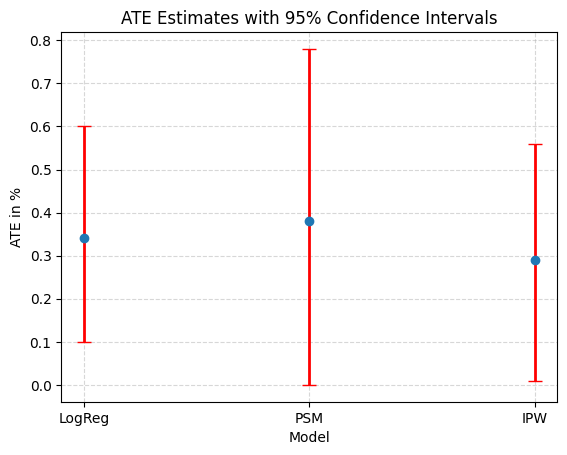

In [33]:
models = ['LogReg', 'PSM', 'IPW']
ates = [0.34, 0.38, 0.29]
lower_errors = [0.24, 0.38, 0.28]
upper_errors = [0.26, 0.40, 0.27]

plt.errorbar(models, ates, 
             yerr=[lower_errors, upper_errors],
             fmt='o', 
             capsize=5,
             ecolor='red',
             elinewidth=2)

plt.xlabel('Model')
plt.ylabel('ATE in %')
plt.title('ATE Estimates with 95% Confidence Intervals')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Sensitivity Analysis
What happens when an assumption does not hold true anymore? In this case, we investigate if:

***A confounding variable is found to be unmeasured***, how much would the ***ATE fluctuate***

OR

***How strong would an unmeasured confounder need to be (in correlation units) to change our conclusions?***

This is a very common occurance, because its impossible to map all possible variables within the dataset.

---

### Rho Parameters (ρ)
The `rho` values quantify the strength of the unmeasured confounding:

- **ρ_UT**: Association between the unmeasured confounder (U) and Treatment (T)
  - Represents how strongly U affects treatment assignment
  - Range: 0 (no effect) to 0.8 (strong effect) in your analysis

- **ρ_UY**: Association between the unmeasured confounder (U) and Outcome (Y)
  - Represents how strongly U affects the outcome
  - Range: 0 (no effect) to 0.8 (strong effect) in your analysis

---

> Note:

> **For Continuous Variables**
>
> When both the confounder (U) and outcome (Y) are continuous:  
>  - `ρ_UY` is exactly the Pearson correlation between U and Y  
>  - `ρ_UT` is the correlation between U and treatment (T)

> **For Binary Variables**
>
> When treatment or outcome is binary (e.g., in logistic regression):  
>  - `rho` approximates a **tetrachoric/polychoric correlation** (theoretical correlation between latent continuous variables)

In [36]:
def sensitivity_analysis_all_methods(df, treatment_col, outcome_col, 
                                   propensity_scores, weights,
                                   matched_indices, treated_outcomes, control_outcomes,
                                   rho_UT_range=np.arange(-0.5, 0.5, 0.1),
                                   rho_UY_range=np.arange(-0.5, 0.5, 0.1),
                                   n_simulations=20):
    """
    Run sensitivity analysis for all three causal inference methods
    """
    
    all_results = []
    treatment = df[treatment_col].values
    outcome = df[outcome_col].values
    
    # CRITICAL: Reset index to ensure alignment
    df_reset = df.reset_index(drop=True)
    matched_indices_reset = matched_indices.reset_index(drop=True)
    
    # Original estimates
    original_ipw = np.average(outcome[treatment == 1], weights=weights[treatment == 1]) - \
                   np.average(outcome[treatment == 0], weights=weights[treatment == 0])
    original_psm = treated_outcomes.mean() - control_outcomes.mean()
    
    # Get original logistic regression ATE (you should have this from before)
    # For now, we'll use IPW as baseline - you can replace with your actual logreg ATE
    original_logreg = 0.0034  # Replace with your actual marginal effect
    
    print(f"Original IPW ATE: {original_ipw:.4f}")
    print(f"Original PSM ATE: {original_psm:.4f}")
    print(f"Original LogReg ATE: {original_logreg:.4f}")
    
    for rho_UT in rho_UT_range:
        for rho_UY in rho_UY_range:
            
            # Run multiple simulations for each (rho_UT, rho_UY) pair
            sim_results = []
            
            for sim in range(n_simulations):
                # Simulate unobserved confounder U
                U = np.random.normal(0, 1, len(df_reset))
                
                # Create confounded outcome
                Y_confounded = outcome + rho_UY * U
                
                # =====================================
                # 1. IPW SENSITIVITY
                # =====================================
                ate_ipw = np.average(Y_confounded[treatment == 1], weights=weights[treatment == 1]) - \
                         np.average(Y_confounded[treatment == 0], weights=weights[treatment == 0])
                
                # =====================================
                # 2. PSM SENSITIVITY (FIXED)
                # =====================================
                # Use reset indices to avoid index mismatch
                matched_treatment = matched_indices_reset[treatment_col].values
                matched_Y_confounded = Y_confounded[matched_indices_reset.index]
                
                matched_treated_confounded = matched_Y_confounded[matched_treatment == 1]
                matched_control_confounded = matched_Y_confounded[matched_treatment == 0]
                ate_psm = matched_treated_confounded.mean() - matched_control_confounded.mean()
                
                # =====================================
                # 3. LOGISTIC REGRESSION SENSITIVITY
                # =====================================
                # 1. Extract X and setup model matrix
                X_cols = [col for col in df_reset.columns if 'deviceCategory_' in col or 'country_' in col]
                X_reg = df_reset[['is paid'] + X_cols]
                X_reg = sm.add_constant(X_reg)

                # Convert boolean columns to int (important for @)
                bool_cols = X_reg.select_dtypes(include='bool').columns
                X_reg[bool_cols] = X_reg[bool_cols].astype(int)

                # Convert to numpy for matrix operations
                X_array = X_reg.values

                # 2. Simulate new binary outcome with confounding in the log-odds
                # NOTE: We assume beta_hat is close to the truth (can be from earlier fit)
                try:
                    logmodel = sm.Logit(outcome, X_reg)
                    result = logmodel.fit(disp=0)
                    beta_hat = result.params.values  # includes intercept
                except:
                    beta_hat = np.zeros(X_array.shape[1])  # fallback if original logit fails

                # Add unobserved confounding to log-odds
                log_odds_confounded = X_array @ beta_hat + rho_UY * U
                prob_confounded = 1 / (1 + np.exp(-log_odds_confounded))

                # 3. Simulate binary outcome from confounded probabilities
                Y_confounded_binary = np.random.binomial(1, prob_confounded)

                # 4. Fit logistic regression to confounded binary outcome
                try:
                    logmodel_confounded = sm.Logit(Y_confounded_binary, X_reg)
                    result_confounded = logmodel_confounded.fit(disp=0, maxiter=100)
                    marginal_eff = result_confounded.get_margeff(dummy=True)
                    ate_logreg = marginal_eff.summary_frame().loc['is paid', 'dy/dx']
                except:
                    ate_logreg = np.nan

                
                sim_results.append({
                    'ate_ipw': ate_ipw,
                    'ate_psm': ate_psm,
                    'ate_logreg': ate_logreg
                })
            
            # Average across simulations
            sim_df = pd.DataFrame(sim_results)
            
            all_results.append({
                'rho_UT': rho_UT,
                'rho_UY': rho_UY,
                
                # IPW results
                'original_ipw': original_ipw,
                'confounded_ipw': sim_df['ate_ipw'].mean(),
                'bias_ipw': sim_df['ate_ipw'].mean() - original_ipw,
                'relative_bias_ipw': (sim_df['ate_ipw'].mean() - original_ipw) / original_ipw if original_ipw != 0 else 0,
                
                # PSM results
                'original_psm': original_psm,
                'confounded_psm': sim_df['ate_psm'].mean(),
                'bias_psm': sim_df['ate_psm'].mean() - original_psm,
                'relative_bias_psm': (sim_df['ate_psm'].mean() - original_psm) / original_psm if original_psm != 0 else 0,
                
                # Logistic regression results
                'original_logreg': original_logreg,
                'confounded_logreg': sim_df['ate_logreg'].mean(),
                'bias_logreg': sim_df['ate_logreg'].mean() - original_logreg,
                'relative_bias_logreg': (sim_df['ate_logreg'].mean() - original_logreg) / original_logreg if original_logreg != 0 else 0
            })
    
    return pd.DataFrame(all_results)




In [37]:
# Make sure to reset the index of your dataframe and matched_indices before running
df_filtered_reset = df_filtered.reset_index(drop=True)
matched_indices_reset = matched_indices.reset_index(drop=True)

final_result = sensitivity_analysis_all_methods(df=df_filtered_reset,
    treatment_col='is paid',
    outcome_col='converted',
    propensity_scores=propensity_scores,
    weights=weights,
    matched_indices=matched_indices_reset,
    treated_outcomes=treated_outcomes,
    control_outcomes=control_outcomes)


Original IPW ATE: 0.0029
Original PSM ATE: 0.0038
Original LogReg ATE: 0.0034


C:\Users\neyma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\neyma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\discrete\discrete_model.py:2409: RuntimeWarning: overflow encountered in exp
  return np.exp(-X)/(1+np.exp(-X))**2
C:\Users\neyma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\discrete\discrete_model.py:2409: RuntimeWarning: invalid value encountered in divide
  return np.exp(-X)/(1+np.exp(-X))**2
C:\Users\neyma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\discrete\discrete_model.py:2409: RuntimeWarning: invali

In [74]:
final_result
final_result.to_csv("sensitivity analysis.csv")

The following plots shows how sensitive the ATE is to unmeasured confounding.

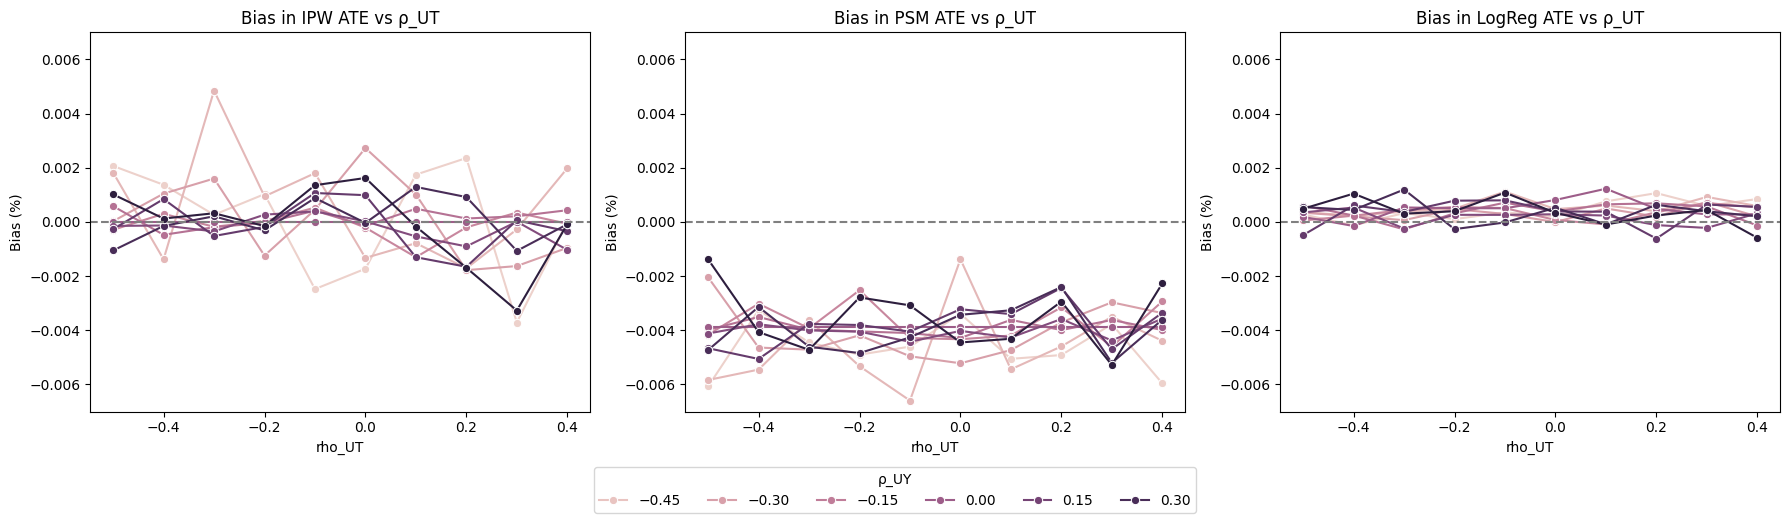

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Create all three plots
sns.lineplot(data=final_result, x='rho_UT', y='bias_ipw', hue='rho_UY', marker='o', ax=axes[0])
axes[0].axhline(0, linestyle='--', color='grey')
axes[0].set_ylabel('Bias (%)')
axes[0].set_title('Bias in IPW ATE vs ρ_UT')

sns.lineplot(data=final_result, x='rho_UT', y='bias_psm', hue='rho_UY', marker='o', ax=axes[1])
axes[1].axhline(0, linestyle='--', color='grey')
axes[1].set_ylabel('Bias (%)')
axes[1].set_title('Bias in PSM ATE vs ρ_UT')

sns.lineplot(data=final_result, x='rho_UT', y='bias_logreg', hue='rho_UY', marker='o', ax=axes[2])
axes[2].axhline(0, linestyle='--', color='grey')
axes[2].set_ylabel('Bias (%)')
axes[2].set_title('Bias in LogReg ATE vs ρ_UT') 

# Get legend info from the first plot (before removing it)
handles, labels = axes[0].get_legend_handles_labels()

# Remove all individual legends
for i in range(3):
    axes[i].set_ylim(-0.007, 0.007)
    axes[i].get_legend().remove()

# Create single figure legend
fig.legend(handles, labels, title='ρ_UY', loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.05))

plt.tight_layout(rect=[0, 0.05, 1, 1])

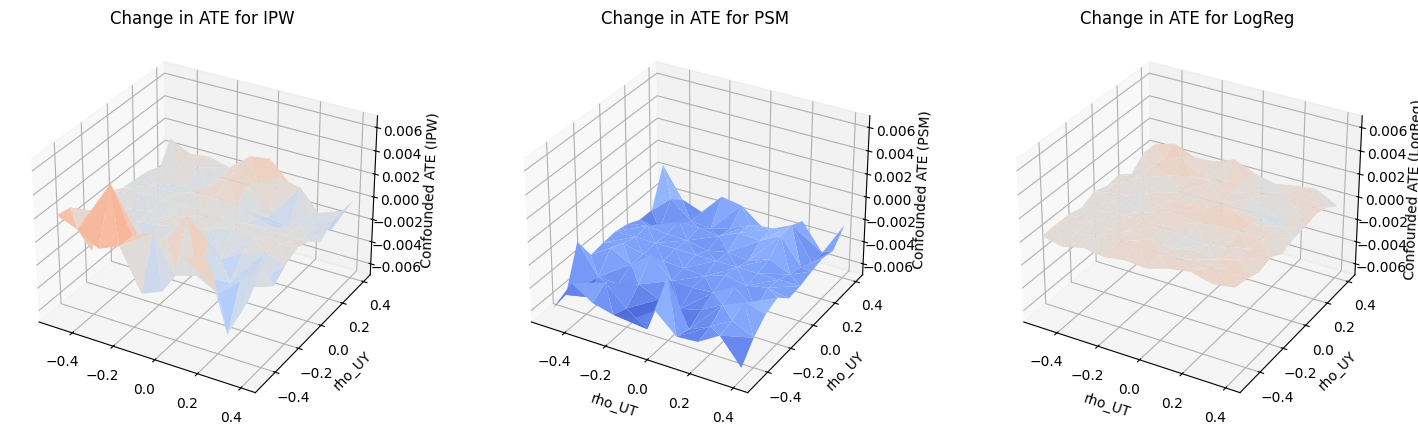

In [72]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import TwoSlopeNorm
fig = plt.figure(figsize= (18,5))
ax = fig.add_subplot(1,3, 1, projection='3d')

a,b,c=final_result['bias_ipw'],final_result['bias_psm'],final_result['bias_logreg']
all_values = np.concatenate([a,b,c])
abs_max = np.max(np.abs(all_values))
norm = TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)
ax.plot_trisurf(final_result['rho_UT'], final_result['rho_UY'], final_result['bias_ipw'],cmap='coolwarm',norm=norm)
ax.set_ylabel('rho_UY')
ax.set_zlabel('Confounded ATE (IPW)')
plt.title('Change in ATE for IPW')
ax.set_zlim(-0.007, 0.007)



ax = fig.add_subplot(1,3, 2, projection='3d')

ax.plot_trisurf(final_result['rho_UT'], final_result['rho_UY'], final_result['bias_psm'],cmap='coolwarm',norm=norm)
ax.set_xlabel('rho_UT')
ax.set_ylabel('rho_UY')
ax.set_zlabel('Confounded ATE (PSM)')
plt.title('Change in ATE for PSM')
ax.set_zlim(-0.007, 0.007)



ax = fig.add_subplot(1,3, 3, projection='3d')

ax.plot_trisurf(final_result['rho_UT'], final_result['rho_UY'], final_result['bias_logreg'],cmap='coolwarm',norm=norm)
ax.set_xlabel('rho_UT')
ax.set_ylabel('rho_UY')
ax.set_zlabel('Confounded ATE (LogReg)')
plt.title('Change in ATE for LogReg')
ax.set_zlim(-0.007, 0.007)





plt.show()


## Sensitivity Analysis Insights
1. LogReg has the most stable and robust ATE. 
2. PSM has consistently lower ATE when there is unmeasured confounding
3. IPW is the most sensitive, fluctuating the most.

---

## Does Logistic Regression's Stability Make It the "Best" Model?

Not necessarily. This simply implies that LogReg is more robust to unmeasured confounding. 

The best model depends on the context of what the client wants to achieve.

### ✅ Why LogReg *Might* Be Preferable in this case
- **Robustness**: Unmeasured confounders are a huge issue, we most likely know that there are some unmeasured confounders
- **Binary Outcomes**: LogReg is designed for it
- Clients want fewer surprises if hidden confounders exist  

### ❗ When LogReg is not the best

1. **Assumptions Violation**  
   - LogReg assumes linear relationship between log-odds and predictors  
   - If this is wrong, PSM/IPW may actually be more reliable  

2. **Data Type**  
   - LogReg is simply better for binary outcomes, like this dataset where you convert or not  
   - When in continous outcomes, we of course do not use LogReg

---

> Of course, the way to go about is to utilise all 3 models, and then pick one to use, compare the ATE to the other 2 models for validation. We are not choosing the best model right now, we are trying to best explain the causal effect.

# Conclusion

---

Knowing the above insights, we can take it that LogReg shall be the main model we pick, and we shall compare the ATE of the other 2 models.


| Model           | Estimated ATE         | 95% Confidence Interval         |
|---------------------|---------------|---------------|
| **Log Regression (Main)**  | 0.0034       | [0.001 , 0.006] |
| **PSM**         | 0.0038       | [0.0 , 0.0078] |
| **IPW** |  0.0029 | [0.0001 , 0.0056] |

---

## We can conclusively say that paid traffic *increases* conversion probability by **0.34%** as compared to organic traffic.

This is supported by the PSM and IPW models, which also showed small but positive ATEs. (magnitudes differing slightly)

---

### Now, our client can make an informed decision on whether to invest in paid traffic or not, based on the expected increase in conversion probability:
### Does the additional 0.34% conversion covers the cost of paid traffic? Doing a Cost-Benefit Analysis would be the next step.